# Synthetic Dataset 1b: ReLU

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import plot_tree

from sklearn.metrics import r2_score, classification_report, confusion_matrix,           \
                            roc_curve, roc_auc_score, plot_confusion_matrix, f1_score,   \
                            balanced_accuracy_score, accuracy_score, mean_squared_error, \
                            log_loss
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier,    \
                                 Lasso, lasso_path
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

import scipy
from scipy import stats

import os
import shutil
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import itertools

import time
import tqdm
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

import PIL
import joblib
import json

# import mysgd

In [16]:
# Import user-defined modules
import sys
import imp
sys.path.append('/Users/arbelogonzalezw/Documents/ML_WORK/LIBS/Lockout_copy/')
import tools_general as tg
import tools_pytorch as tp
import lockout       as ld
imp.reload(tg)
imp.reload(tp)
imp.reload(ld)

<module 'lockout' from '/Users/arbelogonzalezw/Documents/ML_WORK/LIBS/Lockout_copy/lockout.py'>

## Generate and save data

In [261]:
# Generate train, valid, & test datasets
torch.manual_seed(42)
samples = 500
n_features = 100
pi = torch.Tensor([np.pi])

A1 = 2.0
A2 = -3.0
A3 = 4.0

xtrain = torch.rand(samples,n_features)
ytrain = torch.zeros(samples)
ytrain[:] = A1*xtrain[:,0] + A2*xtrain[:,1] + A3*xtrain[:,2]
torch.relu_(ytrain)

xvalid = torch.rand(samples,n_features)
yvalid = torch.zeros(samples)
yvalid[:] = A1*xvalid[:,0] + A2*xvalid[:,1] + A3*xvalid[:,2]
torch.relu_(yvalid)

xtest = torch.rand(samples,n_features)
ytest = torch.zeros(samples)
ytest[:] = A1*xtest[:,0] + A2*xtest[:,1] + A3*xtest[:,2]
torch.relu_(ytest)

y_std = ytrain.std()
print("MEAN of 'ytrain' before adding noise =", ytrain.mean().item())
print("STD of 'ytrain' before adding noise =", y_std.item())

y_std = 1.0*y_std
y_mean = 0.0
print("\nGaussian noise added to 'ytrain with:")
print("- mean =", y_mean)
print("- std =", y_std.item())

ynoise1 = torch.normal(mean=y_mean, std=y_std, size=(samples, 1))
ytrain[:] += ynoise1[:,0]
ynoise2 = torch.normal(mean=y_mean, std=y_std, size=(samples, 1))
yvalid[:] += ynoise2[:,0]

MEAN of 'ytrain' before adding noise = 1.6109306812286377
STD of 'ytrain' before adding noise = 1.3201014995574951

Gaussian noise added to 'ytrain with:
- mean = 0.0
- std = 1.3201014995574951


In [262]:
# Convert to Pandas DataFrames
cols_X = [str(i) for i in range(1, n_features+1)]
df_xtrain = pd.DataFrame(xtrain.numpy(), columns=cols_X)
df_xvalid = pd.DataFrame(xvalid.numpy(), columns=cols_X)
df_xtest  = pd.DataFrame(xtest.numpy(), columns=cols_X)
cols_X = df_xtrain.columns.tolist()

cols_Y = ['target']
df_ytrain = pd.DataFrame(ytrain.numpy(), columns=cols_Y)
df_yvalid = pd.DataFrame(yvalid.numpy(), columns=cols_Y)
df_ytest = pd.DataFrame(ytest.numpy(), columns=cols_Y)

In [263]:
# Save data set
tg.save_data(df_xtrain, df_xtrain, df_xvalid, df_xtest, 
             df_ytrain, df_ytrain, df_yvalid, df_ytest, 'dataset_b/')
tg.save_list(cols_X, 'dataset_b/X.columns')
tg.save_list(cols_Y, 'dataset_b/Y.columns')

# 
print("- xtrain size: {}".format(df_xtrain.shape))
print("- xvalid size: {}".format(df_xvalid.shape))
print("- xtest size: {}".format(df_xtest.shape))

- xtrain size: (500, 100)
- xvalid size: (500, 100)
- xtest size: (500, 100)


## Load Data

In [3]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")
    
# Choose device
# torch.cuda.set_device(6)

-Type of precessor to be used: 'cpu'


In [4]:
# Read data
_, x_train, x_valid, x_test, _, y_train, y_valid, y_test = tp.load_data_reg('dataset_b/')
cols_X = tg.read_list('dataset_b/X.columns')
cols_Y = tg.read_list('dataset_b/Y.columns')

In [5]:
# Normalize data
xtrain, xvalid, xtest, ytrain, yvalid, ytest = tp.normalize_xy(x_train, x_valid, x_test, 
                                                               y_train, y_valid, y_test)

In [6]:
# Create dataloaders
dl_train, dl_valid, dl_test = tp.make_DataLoaders(xtrain, xvalid, xtest, ytrain, yvalid, ytest, 
                                                  tp.dataset_tabular, batch_size=10000)

(train, valid, test) = (1, 1, 1)


In [7]:
# NN architecture with its corresponding forward method
class MyNet(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNet, self).__init__()
        
        self.fc1  = nn.Linear(features, layer_sizes[0], bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.bias = nn.Parameter(torch.randn(layer_sizes[0]), requires_grad=True)

# .Forward function
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = x + self.bias
        return x

In [8]:
# Instantiate model
n_features = len(cols_X)
n_layers = [1]
model = MyNet(n_features, n_layers)
model.eval()

MyNet(
  (fc1): Linear(in_features=100, out_features=1, bias=False)
  (relu): ReLU(inplace=True)
)

## Unregularized

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = False
Last iteration = 10000
Best validation at iteration = 958


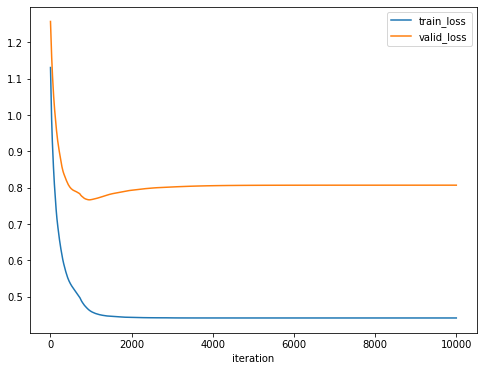

In [282]:
# TRAIN FORWARD
lockout_unconstraint = ld.Lockout(model, lr=5e-3, loss_type=1, optim_id=1, 
                                  save_weights=(True, 'fc1.weight'))

lockout_unconstraint.train(dl_train, dl_valid, epochs=10000, early_stop=20, tol_loss=1e-6,
                           train_how="unconstraint", reset_weights=True)

lockout_unconstraint.path_data.plot(x="iteration", 
                                    y=['train_loss', 'valid_loss'], 
                                    figsize=(8,6))
plt.show()

In [283]:
# Save model, data
tp.save_model(lockout_unconstraint.model_best_valid, 'outputs_b/model_forward_valid_min.pth')
tp.save_model(lockout_unconstraint.model_last, 'outputs_b/model_forward_last.pth')
lockout_unconstraint.path_data.to_csv('outputs_b/data_forward.csv')
lockout_unconstraint.weight_iters.to_csv('outputs_b/w_vs_iters_forward.csv', header=None, index=False)

In [284]:
# Accuracy
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./outputs_b/model_forward_valid_min.pth'))
mm.eval()

xtrain = xtrain.to(device)
ypred = mm(xtrain)
r2 = r2_score(ytrain.detach().numpy(), ypred.detach().numpy())
print("Train R2 = {:.4f}".format(r2))

xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
print("Valid R2 = {:.4f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
print("Test R2  = {:.4f}".format(r2))

Train R2 = 0.5375
Valid R2 = 0.2470
Test R2  = 0.5755


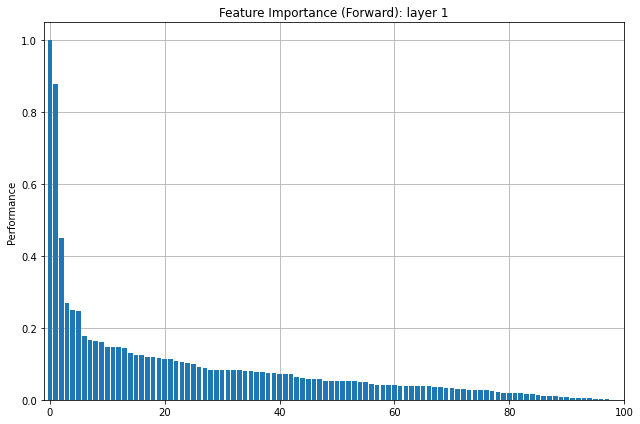

Non zero features: 100


In [22]:
# Weight importance (layer 1)
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./outputs_b/model_forward_valid_min.pth'))
mm.eval()

importance = tp.get_features_importance(mm, 'fc1.weight')

fig, axes = plt.subplots(figsize=(9,6))
x_pos = np.arange(len(importance))
axes.bar(x_pos, importance, zorder=2)
# axes.set_xticks(x_pos)
# axes.set_xticklabels(feature_importance_sorted1.index[idx], rotation='vertical')
axes.set_xlim(-1,len(x_pos))
axes.set_ylabel('Performance')
axes.set_title('Feature Importance (Forward): layer 1')
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig('outputs_b/feature_importance_forward.pdf', bbox_inches='tight')
plt.show()
print("Non zero features: {}".format(len(importance)))

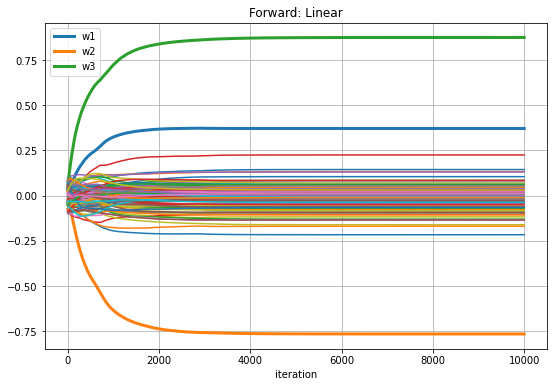

In [286]:
# Plot weights vs iters
ww_iter = pd.read_csv('outputs_b/w_vs_iters_forward.csv', header=None)
ncols = ww_iter.shape[1]
iters = ww_iter.index.tolist()

fig, axes = plt.subplots(figsize=(9,6))
for i in range(ncols):
    if i < 3:
        axes.plot(iters, ww_iter[i], label="w{}".format(i+1), linewidth=3)
    else:
        axes.plot(iters, ww_iter[i])

axes.set_xlabel("iteration")
axes.set_title("Forward: Linear")
axes.legend()
axes.grid(True, zorder=2)

plt.savefig("outputs_b/w_vs_iters_forward.pdf", bbox_inches='tight')
plt.show()

## Lockout

In [289]:
# TRAIN WITH LOCKOUT
model = MyNet(n_features, n_layers)
model.load_state_dict(torch.load('./outputs_b/model_forward_last.pth'))
model.eval()

regul_type = [('fc1.weight', 1)]
regul_path = [('fc1.weight', True)]

lockout_reg = ld.Lockout(model, lr=5e-3, 
                         regul_type=regul_type,
                         regul_path=regul_path, 
                         loss_type=1, tol_grads=1e-2, 
                         save_weights=(True, 'fc1.weight'))

In [290]:
lockout_reg.train(dl_train, dl_valid, dl_test, epochs=20000, early_stop=20, tol_loss=1e-5,
                  train_how="decrease_t0")

Epochs1:   0%|          | 0/20000 [00:00<?, ?it/s]

Path 1: Early stopping = True
        Last iteration = 20


Epochs2:   0%|          | 0/20000 [00:00<?, ?it/s]

Best validation at iteration = 15308


In [291]:
# Save model, data
tp.save_model(lockout_reg.model_best_valid, 'outputs_b/model_lockout_valid_min.pth')
tp.save_model(lockout_reg.model_last, 'outputs_b/model_lockout_last.pth')
lockout_reg.path_data.to_csv('outputs_b/data_lockout.csv')
lockout_reg.weight_iters.to_csv('outputs_b/w_vs_iters_lockout.csv', header=None, index=False)

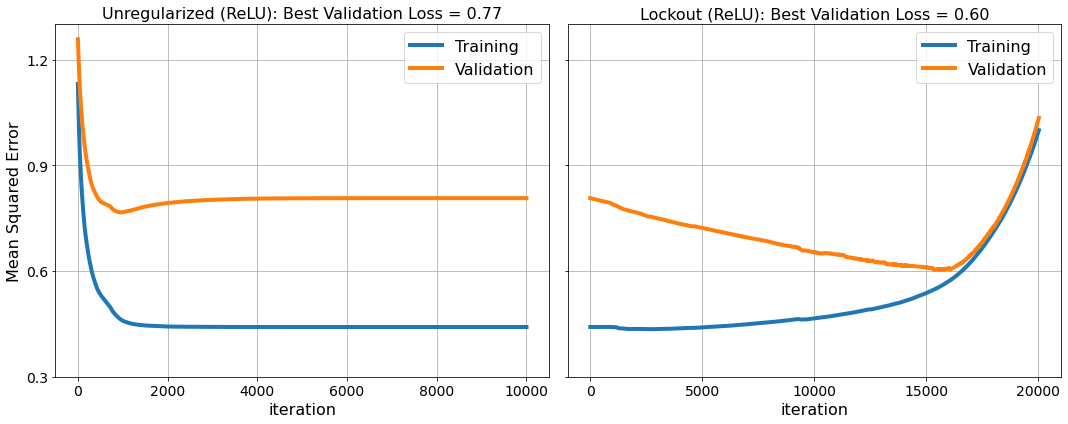

In [18]:
# Plot unconstrained + lockout loss vs iteration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

df1 = pd.read_csv('outputs_b/data_forward.csv')
df2 = pd.read_csv('outputs_b/data_lockout.csv')

axes[0].set_ylim(0.3, 1.3)
axes[0].plot(df1["iteration"], df1["train_loss"], label="Training", linewidth=4)
axes[0].plot(df1["iteration"], df1["valid_loss"], label="Validation", linewidth=4)
axes[0].legend(fontsize=16)
axes[0].set_xlabel("iteration", fontsize=16)
axes[0].set_ylabel("Mean Squared Error", fontsize=16)
axes[0].set_yticks(np.arange(0.3, 1.4, 0.3))
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_title("Unregularized (ReLU): Best Validation Loss = {:.2f}".format(df1["valid_loss"].min()), 
                  fontsize=16)
axes[0].grid(True, zorder=2)

axes[1].set_ylim(0.3, 1.3)
axes[1].plot(df2["iteration"], df2["train_loss"], label="Training", linewidth=4)
axes[1].plot(df2["iteration"], df2["valid_loss"], label="Validation", linewidth=4)
axes[1].legend(fontsize=16)
axes[1].set_xlabel("iteration", fontsize=16)
axes[1].set_yticks(np.arange(0.3, 1.4, 0.3))
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_yticklabels([])
axes[1].set_xticks(np.linspace(0, 20000, 5, endpoint=True))
axes[1].set_title("Lockout (ReLU): Best Validation Loss = {:.2f}".format(df2["valid_loss"].min()), 
                  fontsize=16)
axes[1].grid(True, zorder=2)

plt.tight_layout()
plt.savefig("outputs_b/loss_vs_iter_b.pdf", bbox_inches='tight')
plt.show()

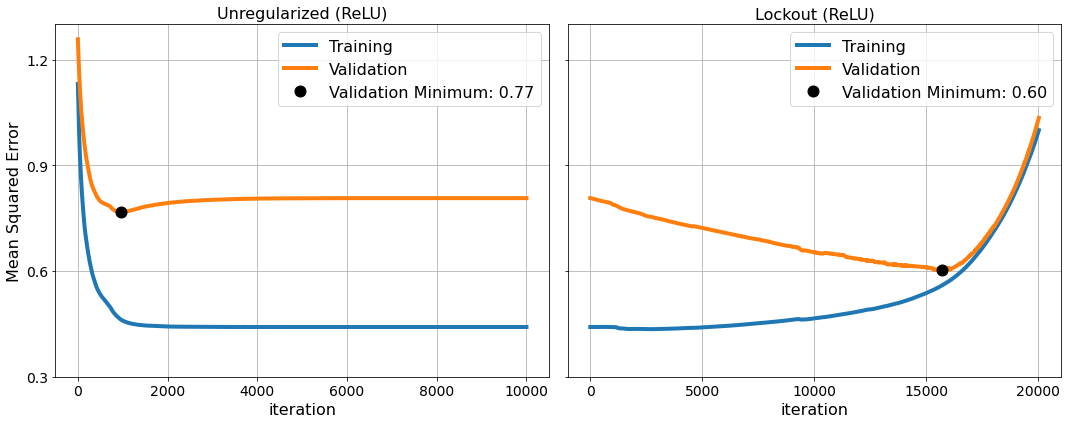

In [45]:
# Plot unconstrained + lockout loss vs iteration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

df1 = pd.read_csv('outputs_b/data_forward.csv')
df2 = pd.read_csv('outputs_b/data_lockout.csv')

axes[0].set_ylim(0.3, 1.3)
axes[0].plot(df1["iteration"], df1["train_loss"], label="Training", linewidth=4)
axes[0].plot(df1["iteration"], df1["valid_loss"], label="Validation", linewidth=4, color="tab:orange")
axes[0].plot(958, df1["valid_loss"].min(), "o", linewidth=4, markersize=11, color="black", 
             label="Validation Minimum: {:.2f}".format(df1["valid_loss"].min()))

axes[0].legend(fontsize=16)
axes[0].set_xlabel("iteration", fontsize=16)
axes[0].set_ylabel("Mean Squared Error", fontsize=16)
axes[0].set_yticks(np.arange(0.3, 1.4, 0.3))
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_title("Unregularized (ReLU)", 
                  fontsize=16)
axes[0].grid(True, zorder=2)

axes[1].set_ylim(0.3, 1.3)
axes[1].plot(df2["iteration"], df2["train_loss"], label="Training", linewidth=4)
axes[1].plot(df2["iteration"], df2["valid_loss"], label="Validation", linewidth=4, color="tab:orange")
axes[1].plot(15700, df2["valid_loss"].min(), "o", linewidth=4, markersize=11, 
             color="black", 
             label="Validation Minimum: {:.2f}".format(df2["valid_loss"].min()))
axes[1].legend(fontsize=16)
axes[1].set_xlabel("iteration", fontsize=16)
axes[1].set_yticks(np.arange(0.3, 1.4, 0.3))
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_yticklabels([])
axes[1].set_xticks(np.linspace(0, 20000, 5, endpoint=True))
axes[1].set_title("Lockout (ReLU)", 
                  fontsize=16)
axes[1].grid(True, zorder=2)

plt.tight_layout()
plt.savefig("outputs_b/loss_vs_iter_b.pdf", bbox_inches='tight')
plt.show()

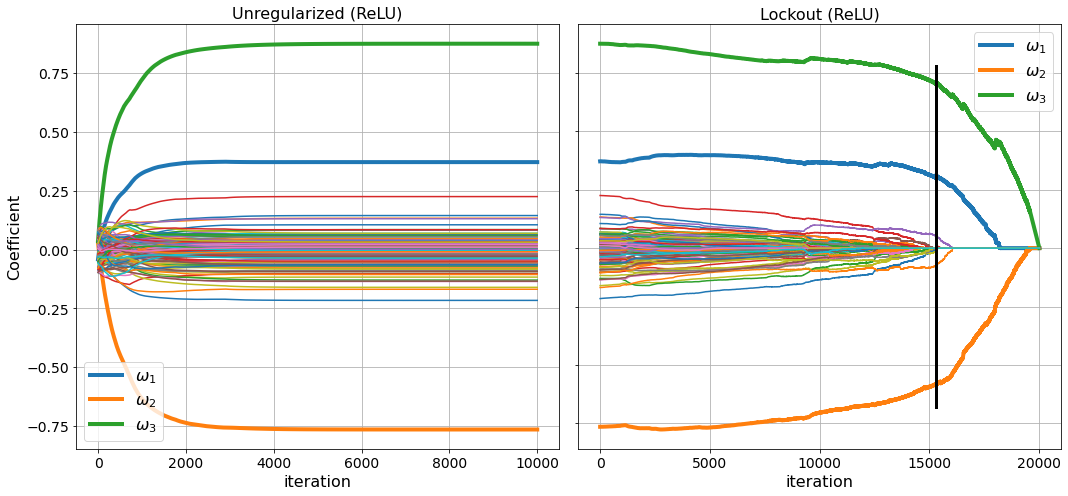

In [16]:
# Plot weights vs iters
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

# Forward
ww_iter = pd.read_csv('outputs_b/w_vs_iters_forward.csv', header=None)
ncols = ww_iter.shape[1]
iters = ww_iter.index.tolist()
for i in range(ncols):
    if i < 3:
        axes[0].plot(iters, ww_iter[i], label="$\omega_{}$".format(i+1), linewidth=4)
    else:
        axes[0].plot(iters, ww_iter[i])

axes[0].set_xlabel("iteration", fontsize=16)
axes[0].set_ylabel("Coefficient", fontsize=16)
axes[0].set_title("Unregularized (ReLU)", fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].legend(fontsize=16)
axes[0].grid(True, zorder=2)

# lockout
ww_iter = pd.read_csv('outputs_b/w_vs_iters_lockout.csv', header=None)
ncols = ww_iter.shape[1]
iters = ww_iter.index.tolist()
for i in range(ncols):
    if i < 3:
        axes[1].plot(iters, ww_iter[i], label="$\omega_{}$".format(i+1), linewidth=4)
    else:
        axes[1].plot(iters, ww_iter[i])

axes[1].set_xlabel("iteration", fontsize=16)
axes[1].set_title("Lockout (ReLU)", fontsize=16)
axes[1].legend(fontsize=16)
axes[1].set_yticklabels([])
axes[1].set_xticks(np.linspace(0, 20000, 5, endpoint=True))
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].grid(True, zorder=2)
axes[1].plot([15308, 15308],[-.68, .78], linewidth=3, color='black')

plt.tight_layout()
plt.savefig("outputs_b/w_vs_iters_b.pdf", bbox_inches='tight')
plt.show()

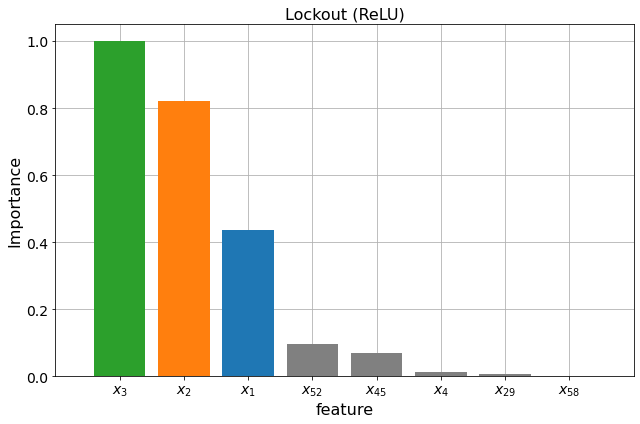

Non zero features: 8


In [17]:
# Features importance (layer 1)
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./outputs_b/model_lockout_valid_min.pth'))
mm.eval()

importance = tp.get_features_importance(mm, 'fc1.weight')
idx = list(importance.index+1)
string_labels = []
for i in idx:
    string_labels.append(r"$x_{}{}{}$".format('{',i,'}'))

fig, axes = plt.subplots(figsize=(9,6))
x_pos = np.arange(len(importance))
axes.bar(x_pos[0], importance.iloc[0], zorder=2, color="tab:green")
axes.bar(x_pos[1], importance.iloc[1], zorder=2, color="tab:orange")
axes.bar(x_pos[2], importance.iloc[2], zorder=2, color="tab:blue")
axes.bar(x_pos[3:], importance.iloc[3:], zorder=2, color="gray")
axes.set_xticks(x_pos)
axes.set_xticklabels(string_labels)
axes.set_xlim(-1,len(x_pos))
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_ylabel('Importance', fontsize=16)
axes.set_xlabel('feature', fontsize=16)
axes.set_title('Lockout (ReLU)', fontsize=16)
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig('outputs_b/feature_importance_lockout_b.pdf', bbox_inches='tight')
plt.show()
print("Non zero features: {}".format(len(importance)))

In [17]:
# Accuracy
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('outputs_b/model_lockout_valid_min.pth'))
mm.eval()

print("Lockout:")
xtrain = xtrain.to(device)
ypred = mm(xtrain)
r2 = r2_score(ytrain.numpy(), ypred.detach().numpy())
print("Train R2 = {:.3f}".format(r2))

xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.numpy(), ypred.detach().numpy())
print("Valid R2 = {:.3f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.numpy(), ypred.detach().numpy())
print("Test R2  = {:.3f}".format(r2))

Lockout:
Train R2 = 0.453
Valid R2 = 0.407
Test R2  = 0.829


In [19]:
# Accuracy
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./outputs_b/model_forward_valid_min.pth'))
mm.eval()

print("Early Stopping:")
xtrain = xtrain.to(device)
ypred = mm(xtrain)
r2 = r2_score(ytrain.detach().numpy(), ypred.detach().numpy())
print("Train R2 = {:.3f}".format(r2))

xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
print("Valid R2 = {:.3f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
print("Test R2  = {:.3f}".format(r2))

Early Stopping:
Train R2 = 0.537
Valid R2 = 0.247
Test R2  = 0.575


In [18]:
# Error
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('outputs_b/model_lockout_valid_min.pth'))
mm.eval()

print("Lockout:")
xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.numpy(), ypred.detach().numpy())
r2 = np.sqrt(1.0 - r2)
print("Valid Error = {:.3f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.numpy(), ypred.detach().numpy())
r2 = np.sqrt(1.0 - r2)
print("Test Error  = {:.3f}".format(r2))

Lockout:
Valid Error = 0.770
Test Error  = 0.414


In [20]:
# Error
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./outputs_b/model_forward_valid_min.pth'))
mm.eval()

print("Early Stopping:")
xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
r2 = np.sqrt(1.0 - r2)
print("Valid Error = {:.3f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
r2 = np.sqrt(1.0 - r2)
print("Test Error  = {:.3f}".format(r2))

Early Stopping:
Valid Error = 0.868
Test Error  = 0.652
